# Deep Recurrent Q-Learning

### Resources

- https://arxiv.org/pdf/1507.06527

In [1]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import time
import torch
import torch.nn as nn
import gymnasium as gym
import ale_py
import minatar
import matplotlib.pyplot as plt

from collections import deque
from tqdm import tqdm
from gymnasium.wrappers import FrameStack
from gymnasium.wrappers.frame_stack import LazyFrames
from stable_baselines3.common.atari_wrappers import (
    AtariWrapper,
    FireResetEnv,
)

gym.register_envs(ale_py)
gym.register_envs(minatar)

from utils.replay import LazyFramesToNumpyWrapper, MetricTracker

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
def display_frame(frame, gray=False):
    if gray:
        plt.imshow(frame, cmap='gray')
    else:
        plt.imshow(frame)
    plt.axis('off')
    plt.show()

In [4]:
def display_multiple_frames(frames):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i], cmap='gray')
        ax.axis('off')
    plt.show()

In [5]:
class FlickeringAtari(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env

    def observation(self, observation, prob=0.3):
        if np.random.rand() < prob:
            return np.zeros_like(observation, dtype=np.uint8)
        return observation

In [6]:
def make_env(game, render='rgb_array'):
    env = gym.make(game, render_mode=render)
    env = AtariWrapper(env, terminal_on_life_loss=False)
    env = LazyFramesToNumpyWrapper(env)
    env = FlickeringAtari(env)
    if "FIRE" in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    return env

In [7]:
env_test = make_env('BreakoutNoFrameskip-v4')

(84, 84, 1)


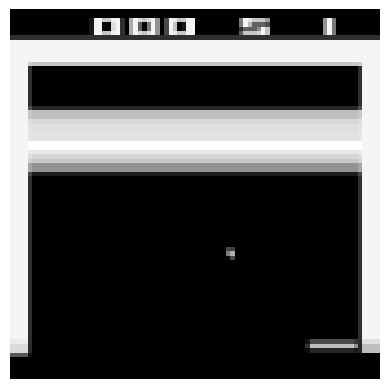

In [36]:
observation, _ = env_test.reset()
print(observation.shape)
display_frame(observation, gray=True)

In [37]:
from copy import deepcopy

class Episode:
    
    def __init__(
        self
    ):
        self.obs = []
        self.actions = []
        self.rewards = []
        self.obs_prime = []
        self.dones = []
        
    def add_step(
        self,
        observation,
        action, 
        reward, 
        observation_prime, 
        terminated
    ):
        self.obs.append(observation)
        self.actions.append(action)
        self.rewards.append(reward)
        self.obs_prime.append(observation_prime)
        self.dones.append(terminated)
        
    def __getitem__(self, index):
        if isinstance(index, slice):
            ep = Episode()
            ep.obs = self.obs[index]
            ep.actions = self.actions[index]
            ep.rewards = self.rewards[index]
            ep.obs_prime = self.obs_prime[index]
            ep.dones = self.dones[index]
            return ep
        elif isinstance(index, tuple):
            arg = index[0]
            pos = index[1]
            if arg == 0: 
                return self.obs[pos]
            elif arg == 1:
                return self.actions[pos]
            elif arg == 2:
                return self.rewards[pos]
            elif arg == 3:
                return self.obs_prime[pos]
            elif arg == 4:
                return self.dones[pos]
         
        return (
            self.obs[index],
            self.actions[index],
            self.rewards[index],
            self.obs_prime[index],
            self.dones[index]
        )
    
    def pad(self, stop):
        new_ep = Episode()
        new_ep.obs = deepcopy(self.obs)
        new_ep.actions = deepcopy(self.actions)
        new_ep.rewards = deepcopy(self.rewards)
        new_ep.obs_prime = deepcopy(self.obs_prime)
        new_ep.dones = deepcopy(self.dones)
        def pad_field(arr, stop, zeros, random_start=None):
            copy_arr = deepcopy(arr)
            if len(arr) > stop:
                copy_arr = copy_arr[random_start:random_start+stop]
            else:
                for i in range(stop):
                    if i >= len(copy_arr):
                        copy_arr.append(zeros)
            return copy_arr
            
        random_start = np.random.randint(low=0, high=(len(new_ep.obs)-stop-1))
        new_ep.obs = pad_field(new_ep.obs, stop, zeros=np.zeros_like(self.obs[0]), random_start=random_start)
        new_ep.actions = pad_field(new_ep.actions, stop, zeros=np.int64(0), random_start=random_start)
        new_ep.rewards = pad_field(new_ep.rewards, stop, zeros=np.float32(0.0), random_start=random_start)
        new_ep.obs_prime = pad_field(new_ep.obs_prime, stop, zeros=np.zeros_like(self.obs_prime[0]), random_start=random_start)
        new_ep.dones = pad_field(new_ep.dones, stop, zeros=True, random_start=random_start)
        
        return new_ep
    
    def __len__(self):
        return len(self.obs)
    
    def __repr__(self):
        return f'Episode of Length {len(self)}'

In [38]:
observation, _ = env_test.reset()
done = False
ep = Episode()
while not done:
    action = env_test.action_space.sample()
    observation_prime, reward, terminated, truncated, _ = env_test.step(action) 
    ep.add_step(
        observation.squeeze(),
        action, 
        reward, 
        observation_prime.squeeze(),
        terminated or truncated
    )
    
    done = terminated or truncated
    observation = observation_prime
ep

Episode of Length 120

In [39]:
padded_ep = ep.pad(100)
ep, padded_ep

(Episode of Length 120, Episode of Length 100)

In [40]:
import random

class ReplayBufferDRQN:
    
    def __init__(self, capacity, device='cuda'):
        self._buffer = deque(maxlen=capacity)
        self.device = device
    
    def store(self, episode):
        self._buffer.append(episode)
    
    def sample(self, batch_size, stop=None):
        batch = random.choices(self._buffer, k=batch_size)
        max_len = len(max(batch, key=len)) if stop is None else stop
        padded_batch = [ep.pad(max_len) for ep in batch]
        
        return (
            self.extract_item(padded_batch, 0, (batch_size, max_len, 1, 84, 84), dtype=torch.float32),
            self.extract_item(padded_batch, 1, (batch_size, max_len, 1), dtype=torch.int64),
            self.extract_item(padded_batch, 2, (batch_size, max_len, 1), dtype=torch.float32),
            self.extract_item(padded_batch, 3, (batch_size, max_len, 1, 84, 84), dtype=torch.float32),
            self.extract_item(padded_batch, 4, (batch_size, max_len, 1), dtype=torch.bool)
        )

    def extract_item(self, batch, arg, shape, dtype):
        batched_values = np.array([val[arg, :] for val in batch]).reshape(shape)
        batched_values = torch.as_tensor(batched_values, dtype=dtype, device=self.device)
        return batched_values

    def __getitem__(self, index):
        return self._buffer[index]
        
    def __len__(self):
        return len(self._buffer)

In [41]:
buffer = ReplayBufferDRQN(10)

observation, _ = env_test.reset()
for _ in range(10):    
    observation, _ = env_test.reset()
    done = False
    ep = Episode()
    while not done:
        action = env_test.action_space.sample()
        observation_prime, reward, terminated, truncated, _ = env_test.step(action) 
        ep.add_step(
            observation.squeeze(),
            action, 
            reward, 
            observation_prime.squeeze(),
            terminated or truncated
        )
        
        done = terminated or truncated
        observation = observation_prime
        
    buffer.store(ep)

In [42]:
for _ in range(10):
    test_obs, test_act, test_rew, test_prime, test_dones = buffer.sample(16, 100)

In [43]:
test_obs.shape, test_act.shape, test_rew.shape, test_prime.shape, test_dones.shape

(torch.Size([16, 100, 1, 84, 84]),
 torch.Size([16, 100, 1]),
 torch.Size([16, 100, 1]),
 torch.Size([16, 100, 1, 84, 84]),
 torch.Size([16, 100, 1]))

In [44]:
def load_buffer(preload, capacity, game):
    env = make_env(game)
    buffer = ReplayBufferDRQN(capacity)

    observation, _ = env.reset()
    for _ in tqdm(range(preload)):    
        observation, _ = env.reset()
        done = False
        ep = Episode()
        while not done:
            action = env_test.action_space.sample()
            observation_prime, reward, terminated, truncated, _ = env.step(action)

            ep.add_step(
                observation.squeeze(),
                action, 
                reward, 
                observation_prime.squeeze(),
                terminated or truncated
            )
            
            done = terminated or truncated
            observation = observation_prime
        
        buffer.store(ep)
            
    return buffer, env

In [45]:
class DRQN(nn.Module):
    
    def __init__(
        self, 
        env,
        in_channels=1, 
        hidden_filters=list([32, 64, 64]),
        hidden_size=512,
        start_epsilon = 0.99,
        max_decay = 0.1,
        device='cuda',
        decay_steps = 1000,  
        *args, 
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.env = env
        self.start_epsilon = start_epsilon
        self.epsilon = start_epsilon
        self.max_decay = max_decay
        self.decay_steps = decay_steps
        self.num_actions = env.action_space.n
        self.hidden_size = hidden_size
        self.device = device
        
        
        self.layers_cnn = nn.Sequential(
            nn.Conv2d(in_channels, hidden_filters[0], kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[0], hidden_filters[1], kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[1], hidden_filters[2], kernel_size=3, stride=1),
            nn.ReLU(),
        )
        

        self.lstm = nn.LSTM(hidden_filters[-1] * 7 * 7, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, self.num_actions)
        
        self.apply(self._init)
    
    def forward(self, x, h0, c0):
        B, T, C, H, W = x.shape
        x_view = x.view(-1, C, H, W)
        x_view = self.layers_cnn(x_view / 255.0)
        
        x_view = x_view.reshape(B, T, -1)
        hidden_states, _ = self.lstm(x_view, (h0, c0))
        output = self.linear(hidden_states)
        
        return output
    
       
    def _init(self, m):
      if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
          nn.init.zeros_(m.bias)
    
    def init_hidden_state(self, batch_size, training=True):
        if training:
            return torch.zeros((1, batch_size, self.hidden_size), device=self.device), torch.zeros((1, batch_size, self.hidden_size), device=self.device)
        else:
            return torch.zeros([1, 1, self.hidden_size], device=self.device), torch.zeros((1, 1, self.hidden_size), device=self.device)
              
    def epsilon_greedy(self, state, dim=-1):
        rng = np.random.random()

        if rng < self.epsilon:
            action = self.env.action_space.sample()
            action = torch.tensor(action)
        else:
            with torch.no_grad():
                h_0, c_0 = self.init_hidden_state(1)
                q_values = self(state, h_0, c_0)
            
            action = torch.argmax(q_values.squeeze(), dim=dim)

        return action

    def epsilon_decay(self, step):
        self.epsilon = self.max_decay + (self.start_epsilon - self.max_decay) * max(0, (self.decay_steps - step) / self.decay_steps)
        


In [106]:
net = DRQN(env_test, start_epsilon=0.9, decay_steps=10).to(device)
h0, c0 = net.init_hidden_state(16)
out = net(test_prime, h0, c0)
maxes = torch.amax(out, dim=-1, keepdim=True)

In [46]:
class MetricTrackerDRQN:
    def __init__(self, window_size=15):
        self.window_size = window_size
        self.rewards = deque(maxlen=window_size)
        self.current_episode_reward = 0
        
    def add_episode_reward(self, reward):
        self.current_episode_reward += reward
        
    def end_episode(self):
        self.rewards.append(self.current_episode_reward)   
        self.current_episode_reward = 0
         
    @property
    def avg_reward(self):
        return np.mean(self.rewards) if self.rewards else 0
        

In [54]:
def train(
    env, 
    name, 
    q_network, 
    target_network, 
    timesteps, 
    replay, 
    train_freq, 
    batch_size, 
    lr,
    gamma, 
    episode_len,
    decay_start,
    C,
    save_step,
):
    loss_func = nn.MSELoss()
    start_time = time.time()
    episode_count = 0
    best_avg_reward = -float('inf')
    metrics = MetricTrackerDRQN()
    
    optimizer = torch.optim.Adam(q_network.parameters(), lr=lr)
    obs, _ = env.reset()
    episode = Episode()
    steps_per_sec = 0
    
    for step in range(1, timesteps+1):
        
        batched_obs = obs.reshape(1, 1, 1, 84, 84)
        action = q_network.epsilon_greedy(torch.as_tensor(batched_obs, dtype=torch.float32, device=device)).cpu().item()
        obs_prime, reward, terminated, truncated, _ = env.step(action)
        
        episode.add_step(
            obs.squeeze(), 
            action,
            reward, 
            obs_prime.squeeze(),
            terminated or truncated
        )
        
        metrics.add_episode_reward(reward)
        obs = obs_prime
        
        
        if step % train_freq == 0:
            observations, actions, rewards, observation_primes, dones = replay.sample(batch_size, episode_len)
            with torch.no_grad():
                h_target, c_target = target_network.init_hidden_state(batch_size)
                q_values_minus = target_network(observation_primes, h_target, c_target)
                boostrapped_values = torch.amax(q_values_minus, dim=-1, keepdim=True)
                
            y_trues = torch.where(dones, rewards, rewards + gamma * boostrapped_values)
            h_0, c_0 = q_network.init_hidden_state(batch_size)
            y_preds = q_network(observations, h_0, c_0)

            loss = loss_func(y_preds.gather(-1, actions), y_trues)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(q_network.parameters(), 10)
            optimizer.step()
        
        if step > decay_start: 
            q_network.epsilon_decay(step)
            target_network.epsilon_decay(step)
        
        if terminated or truncated:
            elapsed_time = time.time() - start_time
            steps_per_sec = step / elapsed_time
            metrics.end_episode()
            episode_count += 1
            
            replay.store(episode)
            obs, _ = env.reset()

            episode = Episode()
        
            if metrics.avg_reward > best_avg_reward and step > save_step:
                best_avg_reward = metrics.avg_reward
                torch.save({
                    'step': step,
                    'model_state_dict': q_network.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'avg_reward': metrics.avg_reward,
                }, f"models/{name}_drqn_best_{step}.pth")
                
        print(f"\rStep: {step:,}/{timesteps:,} | "
                f"Episodes: {episode_count} | "
                f"Avg Reward: {metrics.avg_reward:.1f} | "
                f"Epsilon: {q_network.epsilon:.3f} | "
                f"Steps/sec: {steps_per_sec:.1f}", end="\r")
        
        if step % C == 0:
            target_network.load_state_dict(q_network.state_dict())


In [ ]:
TIMESTEPS = 250000
LR = 1e-3
BATCH_SIZE = 64
C = 500
GAMMA = 0.99
TRAIN_FREQ = 4
DECAY_START = 50000 
FINAL_ANNEAL = 200000

In [49]:
buffer, env = load_buffer(500, 2000, game='BreakoutNoFrameskip-v4')

100%|██████████| 500/500 [01:08<00:00,  7.32it/s]


In [55]:
q_network = DRQN(env, decay_steps=FINAL_ANNEAL).to(device)
target_network = DRQN(env, decay_steps=FINAL_ANNEAL).to(device)
target_network.load_state_dict(q_network.state_dict())

metrics = MetricTracker()

train(
    env=env,
    q_network=q_network, 
    name='frostbite',
    target_network=target_network, 
    timesteps=TIMESTEPS, 
    replay=buffer, 
    train_freq=TRAIN_FREQ, 
    lr=LR, 
    batch_size=BATCH_SIZE, 
    gamma=GAMMA, 
    episode_len=30, 
    decay_start=DECAY_START,
    C=C,
    save_step=150000
) 

KeyboardInterrupt: 

In [ ]:
def test(game, model, num_eps=2):
    env_test = make_env(game, render='human')

    q_network_trained = DRQN(env_test)
    q_network_trained.load_state_dict(torch.load(model, weights_only=False)['model_state_dict'])
    q_network_trained.eval()
    q_network_trained.epsilon = 0.05
    
    
    rewards_list = []

    for episode in range(num_eps):
        print(f'Episode {episode}', end='\r', flush=True)
        obs, _ = env_test.reset()
        done = False
        total_reward = 0
        
        while not done:
            batched_obs = np.expand_dims(obs.squeeze(), axis=0)
            action = q_network_trained.epsilon_greedy(torch.as_tensor(batched_obs, dtype=torch.float32)).cpu().item()
                
            next_observation, reward, terminated, truncated, _ = env_test.step(action)
            total_reward += reward
            obs = next_observation

            done = terminated or truncated
            
        rewards_list.append(total_reward)

    env_test.close()
    print(f'Average episode reward achieved: {np.mean(rewards_list)}')